In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:75% !important; }</style>"))
#%load_ext autoreload
#%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import norm

from semipar.estimation.estimate import semipar_fit
from hackathon_auxiliary import parametric_mte
from hackathon_auxiliary import bootstrap
from hackathon_auxiliary import par_fit

warnings.filterwarnings('ignore')

In [3]:
# load data
toy_data_norm = pd.read_stata("semipar/data/toy_data_normal_errors.dta")
toy_data_nonnorm = pd.read_stata("semipar/data/toy_data_bw2014.dta")

In [4]:
toy_data_norm.head()

,lwage,exp,exp2,momsEdu,distCol,enroll,i,u0,u1,V,truep,mte
0,1.750761,12.333383,152.112320,10.798113,3.131401,1.0,0.321794,0.802584,-0.957227,0.846095,0.878574,-0.263946
1,4.846447,29.095451,846.545288,10.066148,11.846854,1.0,0.531120,-0.013684,0.683647,0.026006,0.711280,0.041436
2,2.884425,9.877062,97.556351,11.661082,16.798515,1.0,1.332776,-0.490128,0.385817,-0.881357,0.674156,0.094290
3,2.639430,4.523223,20.459551,14.799751,25.666601,0.0,-0.270975,0.487344,-0.612845,0.566949,0.616375,0.172012
4,2.303309,17.394547,302.570251,13.996597,36.076962,1.0,0.334015,0.558339,-1.188571,-0.759041,0.335409,0.532512


In [5]:
toy_data_nonnorm.rename(columns={"lwage": "wage",
                        "p1": "truep"},
               inplace=True)

toy_data_norm.rename(columns={"lwage": "wage"},
               inplace=True)

# Observables have a joint normal distribution

In [6]:
%%file semipar/files/toy_data_normal_errors.yml
---
SIMULATION:
    seed: 5062
    agents: 991
    source: 8EF73AA0
ESTIMATION:
    file: semipar/data/toy_data_normal_errors.pkl
    dependent: wage
    indicator: enroll
    semipar: True
    show_output: True
    logit: True
    nbins: 25
    trim_support: True
    rbandwidth: 0.05
    derivative: 1
    degree: 2
    bandwidth: 0.175
    gridsize: 500
    ps_range: [0.005, 0.995]
    truncate: False
    optimizer: SCIPY-BFGS
    output_file: replication.grmp.info
    print_output: 0
    maxiter: 80000
    start: auto
    comparison: 0
    agents: 1000
TREATED:
    params:
    - 1.0
    order:
    - exp
    - exp2
    - momsEdu
UNTREATED:
    params:
    - 1.0
    order:
    - exp
    - exp2
    - momsEdu
CHOICE:
    params:
    - 1.0
    order:
    - momsEdu
    - distCol
DIST:
    params:
    - 0.3
    - 0.05 
    - 0.05
    - 0.3
    - 0.25
    - 1.0 
VARTYPES:
    const: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847656e-08
SCIPY-POWELL:
    xtol: 0.0001
    ftol: 0.0001

Overwriting semipar/files/toy_data_normal_errors.yml


In [7]:
rslt = par_fit("semipar/files/toy_data_normal_errors.yml")
par_quantiles, par_mte, mte_up, mte_d = parametric_mte(rslt, "semipar/files/toy_data_normal_errors.yml")

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                         Probit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Oct 2019   Pseudo R-squ.:                  0.2422
Time:                        12:55:01   Log-Likelihood:                -2626.4
converged:                       True   LL-Null:                       -3465.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
momsEdu        0.1152      0.003     33.230      0.000       0.108       0.122
distCol       -0.0552      0.001    -36.875      0.000      -0.058      -0.052

    Common support lies beteen: 

        0.0493622

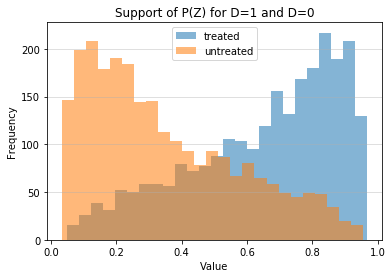

In [8]:
# bandwidth = 0.175
quantiles, mte_u, mte_x, mte = semipar_fit("semipar/files/toy_data_norm.yml")

In [9]:
# Draw n bootstrap samples and calculate MTE estimates.
nbootstraps = 250
mte_boot = bootstrap("semipar/files/toy_data_norm_bootstrap.yml", nbootstraps)

In [10]:
# Get standard error of MTE at each gridpoint u_D
mte_boot_std = np.std(mte_boot, axis=1)

# Compute 90 percent confidence intervals
con_u = mte + norm.ppf(0.95) * mte_boot_std
con_d = mte - norm.ppf(0.95) * mte_boot_std

In [11]:
quantiles1, mte_u1, mte_x1, mte1 = semipar_fit("semipar/files/toy_data_norm1.yml")
quantiles2, mte_u2, mte_x2, mte2 = semipar_fit("semipar/files/toy_data_norm2.yml")
quantiles3, mte_u3, mte_x3, mte3 = semipar_fit("semipar/files/toy_data_norm3.yml")

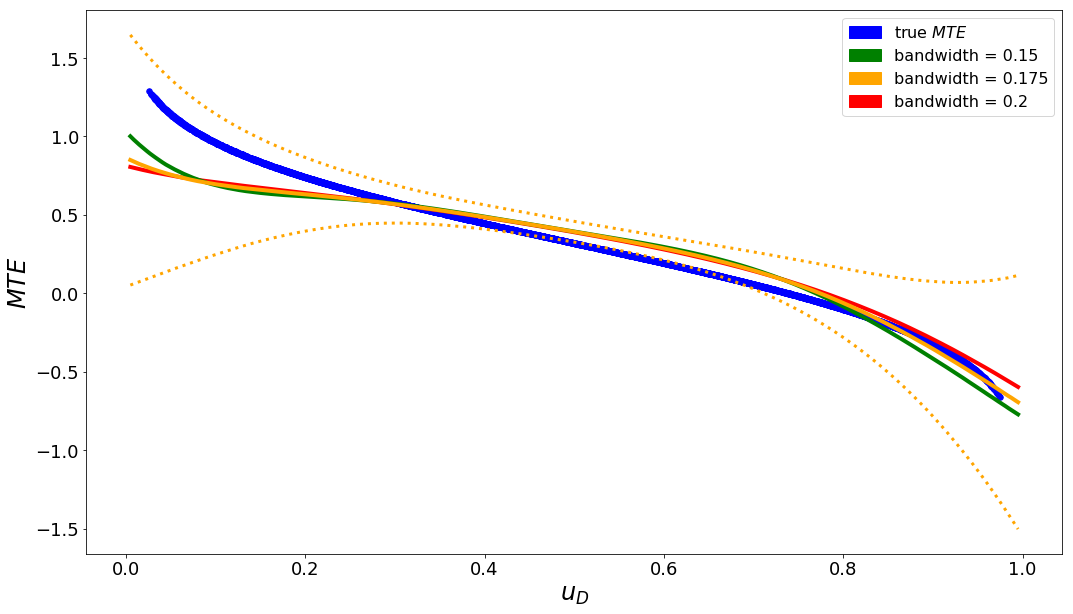

In [12]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=18)

# Plot original curve
plt.scatter(toy_data_norm["truep"], toy_data_norm["mte"], label="true $MTE$", color="blue", s=30)

# semipar results
ax.plot(quantiles1, mte1, label="$bandwidth = 0.2$", color="red", linewidth=4)
ax.plot(quantiles2, mte2, label="$bandwidth = 0.15", color="green", linewidth=4)
ax.plot(quantiles, mte, label="$bandwidth = 0.175$", color="orange", linewidth=4)
ax.plot(quantiles, con_u, color="orange", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="orange", linestyle=":", linewidth=3)

# par results
#ax.plot(par_quantiles, par_mte, label="grmpy $MTE$", color="blueviolet", linewidth=3)
#ax.plot(par_quantiles, mte_up, color="blueviolet", linestyle=':')
#ax.plot(par_quantiles, mte_d, color="blueviolet", linestyle=':')


blue_patch = mpatches.Patch(color="blue", label="true $MTE$")
orange_patch = mpatches.Patch(color="orange", label="bandwidth = 0.175")
green_patch = mpatches.Patch(color="green", label="bandwidth = 0.15")
red_patch = mpatches.Patch(color="red", label="bandwidth = 0.2")
#violet_patch = mpatches.Patch(color="blueviolet", label="parametric $MTE$")
plt.legend(handles=[blue_patch, green_patch, orange_patch, red_patch], prop={"size": 16})

#plt.savefig("normal_semipar.jpg", quality=94)


plt.show()

# Nonnormal Distribution of Unobservables

In [13]:
toy_data_nonnorm.head()

,wage,exp,exp2,momsEdu,distCol,enroll,i,truep,p2,p3,p4,u,V,mte
0,3.342862,23.288361,542.347717,9.817839,25.346506,1.0,1.222360,0.388723,0.151105,0.058738,0.022833,-0.653445,-1.505009,0.367100
1,4.271906,10.508736,110.433525,15.258954,17.376122,1.0,2.410633,0.801922,0.643079,0.515700,0.413551,0.998984,-1.562125,-0.779641
2,3.724988,15.746963,247.966827,12.280519,29.263288,1.0,0.730250,0.412104,0.169830,0.069988,0.028842,0.128747,-0.952385,0.179474
3,2.949666,12.702765,161.360245,10.077416,38.331581,0.0,-1.281590,0.151363,0.022911,0.003468,0.000525,-0.119030,0.250985,1.360819
4,4.378743,19.478725,379.420746,14.888953,21.408171,1.0,0.737557,0.713005,0.508376,0.362474,0.258446,0.232847,-0.175373,0.040813


In [14]:
%%file semipar/files/toy_data_nonnorm.yml
---
SIMULATION:
    seed: 5062
    agents: 991
    source: 8EF73AA0
ESTIMATION:
    file: semipar/data/toy_data_bw2014.pkl
    dependent: wage
    indicator: enroll
    semipar: True
    show_output: True
    logit: True
    nbins: 25
    trim_support: True
    rbandwidth: 0.05
    derivative: 1
    degree: 2
    bandwidth: 0.15
    gridsize: 500
    ps_range: [0.005, 0.995]
    truncate: False
    optimizer: SCIPY-BFGS
    output_file: replication.grmp.info
    print_output: 0
    maxiter: 80000
    start: auto
    comparison: 0
    agents: 1000
TREATED:
    params:
    - 1.0
    order:
    - exp
    - exp2
    - momsEdu
UNTREATED:
    params:
    - 1.0
    order:
    - exp
    - exp2
    - momsEdu
CHOICE:
    params:
    - 1.0
    order:
    - momsEdu
    - distCol
DIST:
    params:
    - 0.3
    - 0.05 
    - 0.05
    - 0.3
    - 0.25
    - 1.0 
VARTYPES:
    const: nonbinary
SCIPY-BFGS:
    gtol: 1.0e-05
    eps: 1.4901161193847656e-08
SCIPY-POWELL:
    xtol: 0.0001
    ftol: 0.0001

Overwriting semipar/files/toy_data_nonnorm.yml


In [15]:
rslt = par_fit("semipar/files/toy_data_nonnorm.yml")
par_quantiles, par_mte, mte_up, mte_d = parametric_mte(rslt, "semipar/files/toy_data_nonnorm.yml")

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Oct 2019   Pseudo R-squ.:                  0.2635
Time:                        12:56:32   Log-Likelihood:                -2552.7
converged:                       True   LL-Null:                       -3465.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
momsEdu        0.2052      0.006     31.796      0.000       0.193       0.218
distCol       -0.0985      0.003    -34.842      0.000      -0.104      -0.093

    Common support lies beteen: 

        0.0427821

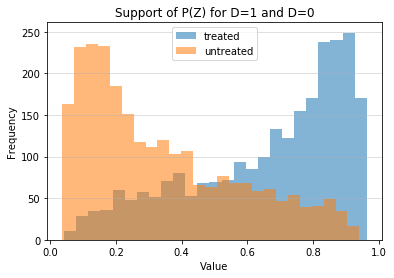

In [16]:
# bandwidth = 0.15
quantiles, mte_u, mte_x, mte = semipar_fit("semipar/files/toy_data_nonnorm.yml")

In [17]:
# Draw n bootstrap samples and calculate MTE estimates.
nbootstraps = 250
mte_boot = bootstrap("semipar/files/toy_data_nonnorm_bootstrap.yml", nbootstraps)

In [18]:
# Get standard error of MTE at each gridpoint u_D
mte_boot_std = np.std(mte_boot, axis=1)

# Compute 90 percent confidence intervals
con_u = mte + norm.ppf(0.95) * mte_boot_std
con_d = mte - norm.ppf(0.95) * mte_boot_std

In [19]:
# Try different bandwidths
quantiles1, mte_u1, mte_x1, mte1 = semipar_fit("semipar/files/toy_data_nonnorm1.yml")
quantiles2, mte_u2, mte_x2, mte2 = semipar_fit("semipar/files/toy_data_nonnorm2.yml")
quantiles3, mte_u3, mte_x3, mte3 = semipar_fit("semipar/files/toy_data_nonnorm3.yml")

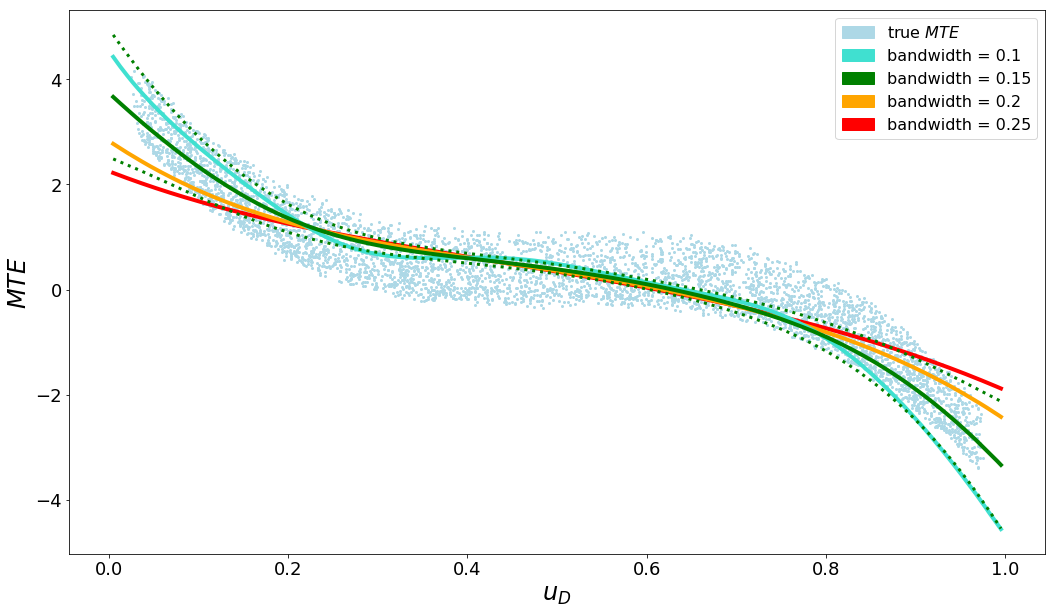

In [20]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=18)

# Plot original curve
plt.scatter(toy_data_nonnorm["truep"], toy_data_nonnorm["mte"], label="$true MTE$", color="lightblue", s=4)

# semipar results
ax.plot(quantiles1, mte1, label="$bandwidth = 0.25$", color="red", linewidth=4)
ax.plot(quantiles2, mte2, label="$bandwidth = 0.2", color="orange", linewidth=4)
ax.plot(quantiles3, mte3, label="$bandwidth = 0.1$", color="turquoise", linewidth=4)
ax.plot(quantiles, mte, label="$bandwidth = 0.15$", color="green", linewidth=4)

ax.plot(quantiles, con_u, color="green", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="green", linestyle=":", linewidth=3)

# par results
#ax.plot(par_quantiles, par_mte, label="grmpy $MTE$", color="blueviolet", linewidth=3)
#ax.plot(par_quantiles, mte_up, color="blueviolet", linestyle=':')
#ax.plot(par_quantiles, mte_d, color="blueviolet", linestyle=':')

#ax.axhline(y=0.32, xmin=0.05, xmax= 0.95, linestyle='--', dashes=(5, 8), color='blue')

blue_patch = mpatches.Patch(color="lightblue", label="true $MTE$")
orange_patch = mpatches.Patch(color="orange", label="bandwidth = 0.2")
green_patch = mpatches.Patch(color="green", label="bandwidth = 0.15")
turquoise_patch = mpatches.Patch(color="turquoise", label="bandwidth = 0.1")
red_patch = mpatches.Patch(color="red", label="bandwidth = 0.25")
violet_patch = mpatches.Patch(color="blueviolet", label="parametric $MTE$")
plt.legend(handles=[blue_patch, turquoise_patch, green_patch, orange_patch, red_patch], prop={"size": 16})

#plt.savefig("nonnormal_semipar.jpg", quality=94)

plt.show()